In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

In [ ]:
folder_path = '/content/drive/My Drive/INFO 4390 Project/'

df1 = pd.read_csv(folder_path + 'CollegeAdmissions_Data.csv')
df2 = pd.read_csv(folder_path + 'HEsegDataviz_CollegeData_4-year_v5.csv')

Note: there are two datasets, each going through the first 5 sections of the rubric.

# Dataset 1 - College Selectivity and Parental Income Bin

This data looks at students who sent ACT/SAT scores to colleges with respect to their parents' income bracket to create summaraize data per college and income bin.


**Data dictionary / important features**

Note: adjusted attributes are adjusted using **adjusted score-sending rates**, the relative fraction of all standardized test takers who send test scores to a given college.

`par_income_bin`: Parent household income group based on percentile in the income distribution.

`par_income_lab`: Parent household income label based on percentile in the income distribution.

`attend`: The attendance rate for each college that would prevail if all students attended at the same average rate as all other students with the same test score. In other words, the fraction of students attending that college among all test-takers within a parent income bin, reweighted by test score.

`rel_attend`: The relative attendance rate can be interpreted as the ratio of the number of students currently attending a given school from a given parental income background to the number of students that would attend the school if all students did so at the same average rate as other students (irrespective of parent income) who share the same test score.

`rel_apply`: The relative application rate can be interpreted as the ratio of the number of students currently applying to a given school from a given parental income background to the number of students that would apply to the school if all students did so at the same average rate as other students (irrespective of parent income) who share the same test score.

`rel_attend_unwgt`: The unweighted relative rates can be interpreted as the ratio of the number of students currently attending a given school from a given parental income background to the number of students that would attend the school if all students did so at the same rate.

`rel_apply_unwgt`: The unweighted relative rates can be interpreted as the ratio of the number of students currently applying to a given school from a given parental income background to the number of students that would apply to the school if all students did so at the same rate.

`rel_attend_cond_app`: The ratio of relative attendance rate to relative application rate.

`tier`: The selectivity and type of the school:
- 1 = Ivy-Plus (Ivy League colleges plus Stanford,
Chicago, Duke, and MIT)
- 2 = Other elite college (Barron’s top selectivity
category, other than the Ivy-plus, both public
and private combined)
- 3 = Highly selective public college (Barron’s 2nd
selectivity group)
- 4 = Highly selective private college (Barron’s 2nd
selectivity group)
- 5 = Selective public college (Barron’s 3rd, 4th,
and 5th selectivity groups)
- 6 = Selective private college (Barron’s 3rd, 4th,
and 5th selectivity groups)

`test_band_tier`: The school group for the test-score band statistics:
- Ivy Plus: SAT 1460-1510
- Top Private: SAT 1410-1460
- NESCAC: SAT 1370-1420
- Tier 2 Private: SAT 1290-1340
- Elite Public: SAT 1180-1230
- Top 100 Private: SAT 1170-1220
- Top 100 Public: SAT 1110-1160
- Other Flagship: SAT 1070-1120

There are some variables that are only exclusive to public colleges, specifically variables including the words "instate" or "oostate", which represent students who are considered in state or out of state. Below, we create two dataframe specific to only private colleges (by filtering and removing the variables that are exclusive to public colleges) and to public colleges.

## Pre Processing

In [ ]:
df1 = df1.rename(columns = {"name" : "college"})
df1 = df1.drop(columns = ["super_opeid"])

# df1_private and df1_public are used for summary statistics
df1_private = df1[df1["public"] == "Private"]
vars = ['college', 'par_income_bin', 'par_income_lab', 'attend',
       'stderr_attend', 'attend_level', 'attend_sat', 'stderr_attend_sat',
       'attend_level_sat', 'rel_apply', 'stderr_rel_apply', 'rel_attend',
       'stderr_rel_attend', 'rel_att_cond_app', 'rel_apply_sat',
       'stderr_rel_apply_sat', 'rel_attend_sat', 'stderr_rel_attend_sat',
       'rel_att_cond_app_sat', 'attend_unwgt', 'stderr_attend_unwgt',
        'attend_unwgt_level', 'rel_attend_unwgt', 'rel_apply_unwgt',
        'stderr_rel_attend_unwgt', 'stderr_rel_apply_unwgt', 'rel_att_cond_app_unwgt',
        'public', 'flagship', 'tier', 'tier_name', 'test_band_tier'
       ]
df1_private = df1_private[vars]
df1_public = df1[df1["public"] == "Public"]

We created the selectivity variables based off of the tier variable. There were 6 types of tiers in the dataset (refer to data dictionary). We created 3 selectivity tiers based on the tier types: tiers 1 and 2 (Ivy Plus, other elite colleges) were considered a part of the "elite" selectivity tier, tiers 3 and 4 (highly selective private and public) were combined into the "highly selective" tier, and 5 and 6 (selective publics and privates) were combined into the "selective" tier. To create the selectivity tiers as outcome variables (binary), we added the binary versions of the different types of tiers.

In [ ]:
# df1_sum_hot is used for summary statistics
df1_sum_hot = pd.get_dummies(df1, columns = ['tier'])
df1_sum_hot["elite_selective"] = df1_sum_hot["tier_Ivy Plus"] + df1_sum_hot["tier_Other elite schools (public and private)"]
df1_sum_hot["highly_selective"] = df1_sum_hot["tier_Highly selective private"] + df1_sum_hot["tier_Highly selective public"]
df1_sum_hot["selective"] = df1_sum_hot["tier_Selective private"] + df1_sum_hot["tier_Selective public"]

# df1_one_hot is used for models
df1_one_hot = pd.get_dummies(df1, columns = ['par_income_lab', 'tier', 'public'])

df1_one_hot["elite_selective"] = df1_one_hot["tier_Ivy Plus"] + df1_one_hot["tier_Other elite schools (public and private)"]
df1_one_hot["highly_selective"] = df1_one_hot["tier_Highly selective private"] + df1_one_hot["tier_Highly selective public"]
df1_one_hot["selective"] = df1_one_hot["tier_Selective private"] + df1_one_hot["tier_Selective public"]

df1_one_hot = df1_one_hot.rename(columns = {"par_income_lab_0-20" : "bin_0-20",
                                            "par_income_lab_20-40" : "bin_20-40",
                                            "par_income_lab_40-60" : "bin_40-60",
                                            "par_income_lab_60-70" : "bin_60-70",
                                            "par_income_lab_70-80" : "bin_70-80",
                                            "par_income_lab_80-90" : "bin_80-90",
                                            "par_income_lab_90-95" : "bin_90-95",
                                            "par_income_lab_95-96" : "bin_95-96",
                                            "par_income_lab_96-97" : "bin_96-97",
                                            "par_income_lab_97-98" : "bin_97-98",
                                            "par_income_lab_98-99" : "bin_98-99",
                                            "par_income_lab_99-99.9" : "bin_99-99.9",
                                            "par_income_lab_Top 1" : "top_1",
                                            "par_income_lab_Top 0.1" : "top_0.1",
                                            "public_Private" : "private",
                                            "public_Public" : "public"})

df1_one_hot = df1_one_hot.drop(columns = ["tier_Highly selective private",
                                          "tier_Highly selective public",
                                          "tier_Ivy Plus", "tier_Other elite schools (public and private)",
                                          "tier_Selective private", "tier_Selective public",
                                          "par_income_bin"])

## Summary Statistics

The initial dataframe contained 1,946 rows and 81 columns.

Four datasets were created from this initial dataframe.
- df1_private is the dataset that is filtered for private colleges only. This dataset has 1232 rows and 32 columns. This will be used mainly for creating summary statistics.
- df1_public is the dataset that is filtered for public colleges only. This dataset has 714 rows and 80 columns. This will be used mainly for creating summary statistics.
- df1_sum_hot is the dataset where the categorical variable "tier" was turned into a one-hot vector. This dataset has 1946 rows and 88 columns. This will be used mainly for creating summary statistics.
- df1_one_hot is the dataset where the categorical variables "par_income_lab", "tier", and "public" were turned into one-hot vectors. This dataset has 1946 rows and 95 columns. This will be used mainly for creating models.

Our sensitive attribute is the parental income bin, which will be our indicator for socioeconomic status of a student.

The outcome variable that we would be predicting is the selectivity of the college. There are three selectivity statuses: elite selective (for Ivy Plus and other elite colleges), highly selective, and selective.

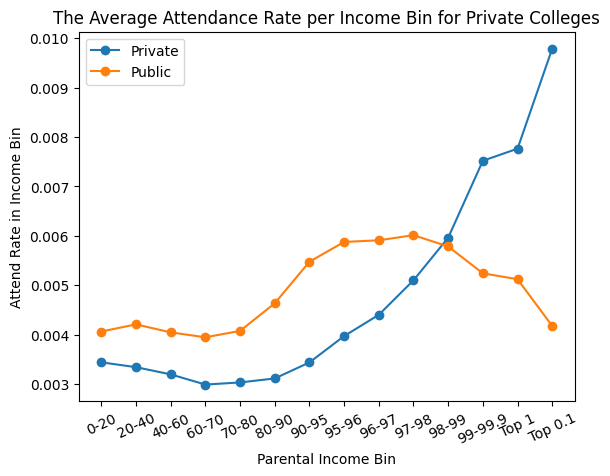

In [ ]:
# Attendance Rate for students in same income bin for private and public colleges
plt.plot(df1_private.groupby("par_income_lab", sort = False).mean("attend")["attend"], marker = "o")
plt.plot(df1_public.groupby("par_income_lab", sort = False).mean("attend")["attend"], marker = "o")
plt.xlabel("Parental Income Bin")
plt.xticks(rotation = 25)
plt.ylabel("Attend Rate in Income Bin")
plt.title("The Average Attendance Rate per Income Bin for Private Colleges")
plt.legend(["Private", "Public"])
plt.show()

The attendance rate is the fraction of students attending a given college among all test-takers within a parent income bin, reweighted by test score. For private colleges, the attendance rate generally increases as the income bin increases. From income bin 90-95 to Top 0.1, the attendance rate increases significantly. For public colleges, the attendance rate is somewhat stagnant until bins 70-80 to 95-96, where it increases. It then plateaus and then decreases, starting at bin 98-99.

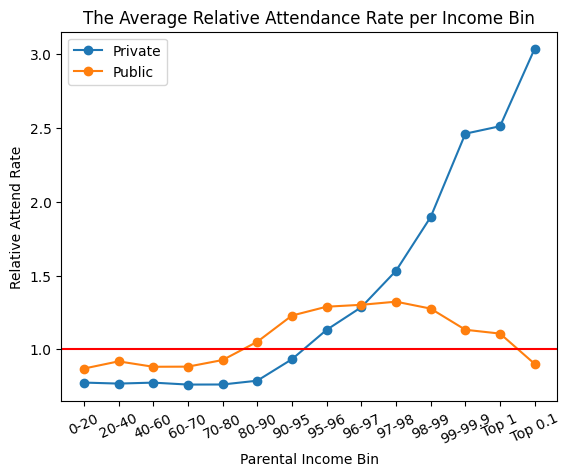

In [ ]:
# Relative Attendance Rate for students for private and public colleges
plt.plot(df1_private.groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"], marker = "o")
plt.plot(df1_public.groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"], marker = "o")

plt.xlabel("Parental Income Bin")
plt.xticks(rotation = 25)
plt.ylabel("Relative Attend Rate")
plt.title("The Average Relative Attendance Rate per Income Bin")
plt.legend(["Private", "Public"])
plt.axhline(y = 1, color = "r")
plt.show()

The relative attendance rate is the ratio of the number of students currently attending a given school from a given parental income bin to the number of students that would attend the school if all students did so at the same average rate as other students, regardless of income bin. A relative attendance of 1 would indicate that the proportion of students attending from a certain income bin is the same as the proportion of the mean attendance rates of all income bins for the college. A relative attendance of 1 will be a good baseline.

For private colleges from bins 0-20 to 90-95, the relative attendance is below the baseline. From the bins onwards, the relative attendance rate significantly increases, reaching its peak at bin Top 0.1 with a relative attendance of at least 3. For public colleges, the relative attendance hovers around the baseline. From bins 80-90 to Top 1, the relative attendance is slightly above the baseline, and for all other bins, it is slighly below. This graph indicates that students from richer families seem to have higher relative attendance rates, and thus higher rates of going to private colleges compared to students from poorer families. This graph also shows that students from all parental income bins have relatively similar relative attendance rates.

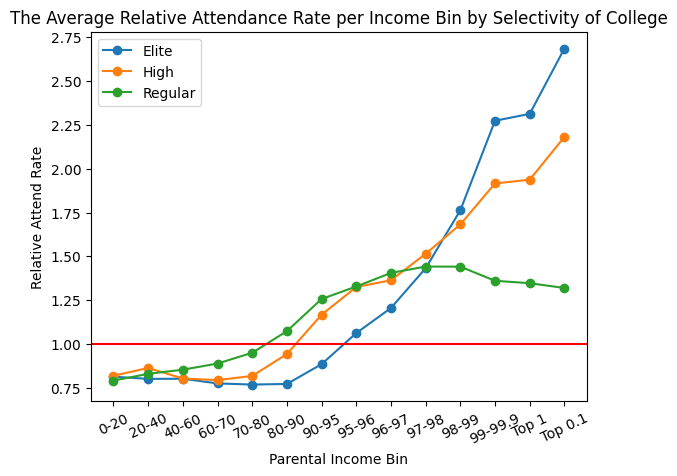

In [ ]:
# Relative Attendance Rate for students for selectivity

plt.plot(df1_sum_hot[df1_sum_hot["elite_selective"] == 1].groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"], marker = "o")
plt.plot(df1_sum_hot[df1_sum_hot["highly_selective"] == 1].groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"], marker = "o")
plt.plot(df1_sum_hot[df1_sum_hot["selective"] == 1].groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"], marker = "o")

plt.xlabel("Parental Income Bin")
plt.xticks(rotation = 25)
plt.ylabel("Relative Attend Rate")
plt.title("The Average Relative Attendance Rate per Income Bin by Selectivity of College")
plt.legend(["Elite", "High", "Regular"])
plt.axhline(y = 1, color = "r")
plt.show()

For colleges with elite selectivity, students with parental income bins from 0-20 to 90-95 have a relative attendance below the baseline. From the bins onward, there is a sharp increase and the relative attendance rate is above the baseline, with a peak relative attendnace rate of almost 2.75 for the Top 0.1. For colleges with high selectivity, students with parental income bins from 0-20 to 80-90 have a relative attendance below the baseline. From the bins onward, they have a relative attendance above the baseline and they increase as the income bin increases. The peak for highly selective colleges is a relative attedance rate around 2.25 for the top 0.1. For colleges with regular selectivity, students with parental income bins 0-20 to 70-80 are below the baseline. The relative attendance increases until it gets to the 98-99 bin, where it starts to decrease. The peak of the relative attendance is about 1.50 at the 98-99 bin.

Elite selective colleges have the steepest increase, followed by highly selective colleges. It seems that overall, an increase in the parental income bin results in an increase in the relative attendance rate, with the exception of the top bins for regular selective colleges.

In [ ]:
# Mean, Median, Standard Deviation for outcome variables
outputs = ["elite_selective", "highly_selective", "selective"]
print()
for i in range(len(outputs)):
  avg_i = df1_one_hot[outputs[i]].mean()
  med_i = df1_one_hot[outputs[i]].median()
  std_i = df1_one_hot[outputs[i]].std()
  print(f"Mean for {outputs[i]}: {avg_i:.4f}")
  print(f"Median for {outputs[i]}: {med_i:.4f}")
  print(f"Standard Deviation for {outputs[i]}: {std_i:.4f}")
  print()


Mean for elite_selective: 0.5180
Median for elite_selective: 1.0000
Standard Deviation for elite_selective: 0.4998

Mean for highly_selective: 0.2518
Median for highly_selective: 0.0000
Standard Deviation for highly_selective: 0.4342

Mean for selective: 0.2302
Median for selective: 0.0000
Standard Deviation for selective: 0.4211



Since the outcome variables (selectivities) are binary, the values can only be 0 or 1. From the medians, we can see that most of the colleges in the dataset are elite_selective (median = 1) while there aren't as many highly selective or selective colleges (medians = 0 each).

In [ ]:
# Mean, Median, Standard Deviation for sensitive variables
sensitive = ["bin_0-20", "bin_20-40", "bin_40-60", "bin_60-70", "bin_70-80",
             "bin_80-90", "bin_90-95", "bin_95-96", "bin_96-97", "bin_97-98",
             "bin_98-99", "bin_99-99.9", "top_1", "top_0.1"]

print()
for i in range(len(sensitive)):
  avg_i = df1_one_hot[sensitive[i]].mean()
  med_i = df1_one_hot[sensitive[i]].median()
  std_i = df1_one_hot[sensitive[i]].std()
  print(f"Mean for {sensitive[i]}: {avg_i:.4f}")
  print(f"Median for {sensitive[i]}: {med_i:.4f}")
  print(f"Standard Deviation for {sensitive[i]}: {std_i:.4f}")
  print()


Mean for bin_0-20: 0.0714
Median for bin_0-20: 0.0000
Standard Deviation for bin_0-20: 0.2576

Mean for bin_20-40: 0.0714
Median for bin_20-40: 0.0000
Standard Deviation for bin_20-40: 0.2576

Mean for bin_40-60: 0.0714
Median for bin_40-60: 0.0000
Standard Deviation for bin_40-60: 0.2576

Mean for bin_60-70: 0.0714
Median for bin_60-70: 0.0000
Standard Deviation for bin_60-70: 0.2576

Mean for bin_70-80: 0.0714
Median for bin_70-80: 0.0000
Standard Deviation for bin_70-80: 0.2576

Mean for bin_80-90: 0.0714
Median for bin_80-90: 0.0000
Standard Deviation for bin_80-90: 0.2576

Mean for bin_90-95: 0.0714
Median for bin_90-95: 0.0000
Standard Deviation for bin_90-95: 0.2576

Mean for bin_95-96: 0.0714
Median for bin_95-96: 0.0000
Standard Deviation for bin_95-96: 0.2576

Mean for bin_96-97: 0.0714
Median for bin_96-97: 0.0000
Standard Deviation for bin_96-97: 0.2576

Mean for bin_97-98: 0.0714
Median for bin_97-98: 0.0000
Standard Deviation for bin_97-98: 0.2576

Mean for bin_98-99: 0.

Since every college has entries for all of the bins, it makes sense that they all have the same mean/median/std; there is equally the same amount of them in the dataset.

A variable based on the college and parental income bin is the attendance rate. The average attendance rate over all colleges and income bins was 0.0048, with a median of 0.0030.

We calculate the means and medians for attendance rate grouped by parental income label. We notice that higher incomes have higher attendance rates.

In [ ]:
# Attendance rate - Overall mean and median
avg1 = df1.mean(numeric_only = True)["attend"]
print(f"Mean attendance rate for all: {avg1:.4f}")
med1 = df1.median(numeric_only = True)["attend"]
print(f"Median attendance rate for all: {med1:.4f}")

# Attendance rate - Mean and median grouped by income
avg_group1 = df1.groupby("par_income_lab", sort = False).mean("attend")["attend"]
med_group1 = df1.groupby("par_income_lab", sort = False).median("attend")["attend"]

k = avg_group1.keys()
print()
for i in range(len(k)):
  avg_k = avg_group1[i]
  med_k = med_group1[i]
  key = k[i]
  print(f"Mean attendance rate for {key}: {avg_k:.4f}")
  print(f"Median attendance rate for {key}: {med_k:.4f}")
  print()


Mean attendance rate for all: 0.0048
Median attendance rate for all: 0.0030

Mean attendance rate for 0-20: 0.0037
Median attendance rate for 0-20: 0.0023

Mean attendance rate for 20-40: 0.0037
Median attendance rate for 20-40: 0.0023

Mean attendance rate for 40-60: 0.0035
Median attendance rate for 40-60: 0.0022

Mean attendance rate for 60-70: 0.0033
Median attendance rate for 60-70: 0.0022

Mean attendance rate for 70-80: 0.0034
Median attendance rate for 70-80: 0.0022

Mean attendance rate for 80-90: 0.0037
Median attendance rate for 80-90: 0.0024

Mean attendance rate for 90-95: 0.0042
Median attendance rate for 90-95: 0.0028

Mean attendance rate for 95-96: 0.0047
Median attendance rate for 95-96: 0.0031

Mean attendance rate for 96-97: 0.0050
Median attendance rate for 96-97: 0.0032

Mean attendance rate for 97-98: 0.0054
Median attendance rate for 97-98: 0.0039

Mean attendance rate for 98-99: 0.0059
Median attendance rate for 98-99: 0.0042

Mean attendance rate for 99-99.9: 

Another variable based on the college and parental income bin is the relative attendance. The average relative attendance rate overall colleges and incomes is 1.2733, with a median of 1.0259.

By calculating the means and medians for relative attendance grouped by parental income bin, we notice that higher incomes tend to have higher relative attendance rates.

In [ ]:
# Relative attendance rate - Overall mean and median
avg1 = df1.mean(numeric_only = True)["rel_attend"]
print(f"Mean attendance rate for all: {avg1:.4f}")
med1 = df1.median(numeric_only = True)["rel_attend"]
print(f"Median attendance rate for all: {med1:.4f}")

# Relative attendance rate - Mean and median grouped by income
avg_group1 = df1.groupby("par_income_lab", sort = False).mean("rel_attend")["rel_attend"]
med_group1 = df1.groupby("par_income_lab", sort = False).median("rel_attend")["rel_attend"]

k = avg_group1.keys()
print()
for i in range(len(k)):
  avg_k = avg_group1[i]
  med_k = med_group1[i]
  key = k[i]
  print(f"Mean relative attendance rate for {key}: {avg_k:.4f}")
  print(f"Median relative attendance rate for {key}: {med_k:.4f}")
  print()


Mean attendance rate for all: 1.2733
Median attendance rate for all: 1.0259

Mean relative attendance rate for 0-20: 0.8103
Median relative attendance rate for 0-20: 0.7204

Mean relative attendance rate for 20-40: 0.8239
Median relative attendance rate for 20-40: 0.7262

Mean relative attendance rate for 40-60: 0.8146
Median relative attendance rate for 40-60: 0.7916

Mean relative attendance rate for 60-70: 0.8066
Median relative attendance rate for 60-70: 0.8122

Mean relative attendance rate for 70-80: 0.8233
Median relative attendance rate for 70-80: 0.8178

Mean relative attendance rate for 80-90: 0.8850
Median relative attendance rate for 80-90: 0.8408

Mean relative attendance rate for 90-95: 1.0421
Median relative attendance rate for 90-95: 0.9976

Mean relative attendance rate for 95-96: 1.1900
Median relative attendance rate for 95-96: 1.1598

Mean relative attendance rate for 96-97: 1.2918
Median relative attendance rate for 96-97: 1.2562

Mean relative attendance rate for 

## Research Question

**Research Question**

How does parental income status affects the probability of getting into a selective college?

**Hypothesis**

As parental income increases, the probability of getting into elite selective colleges (like Ivy Plus colleges) increases.

As parental income increases, the probability of getting into highly selective colleges increases. (Note: the change will probably be less significant than the previous selectivity).

As parental income increases, the probability of getting into selective colleges increases. (Note: the change will probably be less significant than the previous selectivity).

**Analysis**
We will create 3 logistic regression models, each predicting the selectivity outcome since we have one-hot encoded the tier into 3 categories (elite, highly, and regular selectivities). Our sensitive features that we are interested in are the parental income bins.

## Models for our first dataset - Parental Income on Selectivity of Institution Analysis

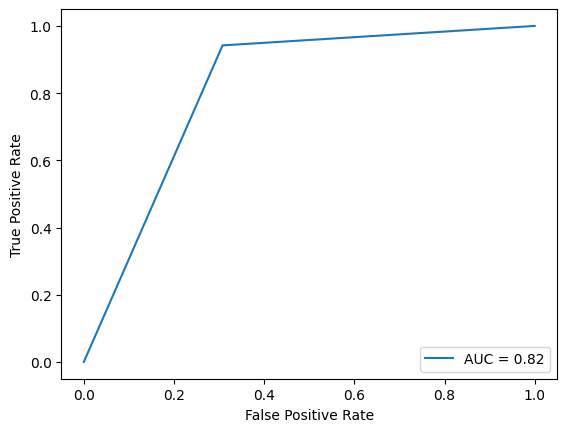

In [ ]:
# Logistic regression: outcome is elite selective
df1_log = df1_one_hot[df1_one_hot["rel_attend"].notna()]
df1_log = df1_log[["rel_attend", 'bin_0-20', 'bin_20-40', 'bin_40-60', 'bin_60-70', 'bin_70-80',
       'bin_80-90', 'bin_90-95', 'bin_95-96', 'bin_96-97', 'bin_97-98',
       'bin_98-99', 'bin_99-99.9', 'top_0.1', 'top_1', 'private', 'public', 'elite_selective',
                   'highly_selective', 'selective']]

df1_train, df1_test = train_test_split(df1_log, test_size = 0.2, random_state = 0)
inputs_select = df1_log.columns[:17]

X = df1_train[inputs_select]
y = df1_train["elite_selective"]
model = LogisticRegression(penalty = None).fit(X, y)

test_pred = model.predict(df1_test[inputs_select])
test_true_all = df1_test["elite_selective"]

fpr, tpr, thresholds = metrics.roc_curve(test_true_all, test_pred)
auc_all = metrics.roc_auc_score(test_true_all, test_pred)
roc_curve = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc_all)
roc_curve.plot()
plt.show()

In [ ]:
# Outcome = elite selective
print(f"auc for all: {auc_all:.4f}")

bins = ['bin_0-20', 'bin_20-40', 'bin_40-60', 'bin_60-70', 'bin_70-80',
       'bin_80-90', 'bin_90-95', 'bin_95-96', 'bin_96-97', 'bin_97-98',
       'bin_98-99', 'bin_99-99.9', 'top_1', 'top_0.1']

def metric_bin_generate(metric, outcome, name):
  for i in range(len(bins)):
    bin = bins[i]
    test_bin_pred = test_pred[df1_test[bin] == 1]
    bin_test = df1_test.loc[df1_test[bin] == 1]
    test_true_bin = bin_test[outcome]
    metric_bin = metric(test_true_bin, test_bin_pred)
    print(f"{name} for income bin {bin[4:]}: {metric_bin:.4f}")

metric_bin_generate(metrics.roc_auc_score, "elite_selective", "auc")

fpr_all = metrics.precision_score(test_true_all, test_pred)
print()
print(f"FPR for all: {fpr_all:.4f}")
metric_bin_generate(metrics.precision_score, "elite_selective", "FPR")
print()
m_inter_ = model.intercept_
m_coefs = model.coef_

for i in range(len(inputs_select)):
  print(f"{inputs_select[i]} coefficient is: {m_coefs[0][i]:.4f}")

auc for all: 0.8172
auc for income bin 0-20: 0.8750
auc for income bin 20-40: 0.8155
auc for income bin 40-60: 0.7857
auc for income bin 60-70: 0.7278
auc for income bin 70-80: 0.8411
auc for income bin 80-90: 0.8706
auc for income bin 90-95: 0.7276
auc for income bin 95-96: 0.7976
auc for income bin 96-97: 0.8750
auc for income bin 97-98: 0.7720
auc for income bin 98-99: 0.7898
auc for income bin 99-99.9: 0.8155
auc for income bin 1: 0.8667
auc for income bin 0.1: 0.8920

FPR for all: 0.7769
FPR for income bin 0-20: 0.8500
FPR for income bin 20-40: 0.7333
FPR for income bin 40-60: 0.6250
FPR for income bin 60-70: 0.6923
FPR for income bin 70-80: 0.8750
FPR for income bin 80-90: 0.8421
FPR for income bin 90-95: 0.6471
FPR for income bin 95-96: 0.6842
FPR for income bin 96-97: 0.8000
FPR for income bin 97-98: 0.7222
FPR for income bin 98-99: 0.7778
FPR for income bin 99-99.9: 0.8462
FPR for income bin 1: 0.8000
FPR for income bin 0.1: 0.9333

rel_attend coefficient is: -0.3142
bin_0-20 

Note: there is an issue with the model for highly selective. We are trying to figure out why it has an auc of 0.5 plus the warnings for the metric calculations. We are unsure if it is purely just a bad model, or if there are some technical mishaps somewhere.

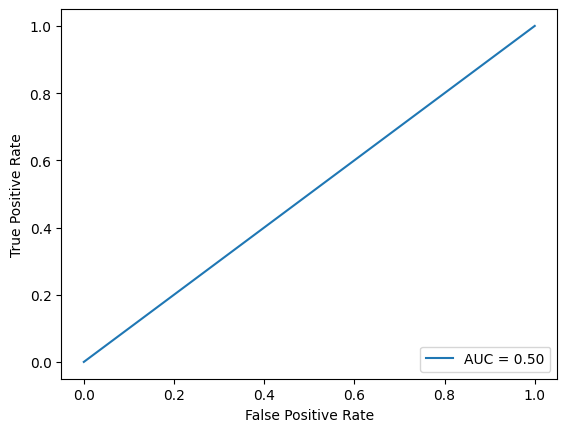

In [ ]:
# Logistic regression: outcome is highly selective
df1_train, df1_test = train_test_split(df1_log, test_size = 0.2, random_state = 0)

X = df1_train[inputs_select]
y = df1_train["highly_selective"]
model = LogisticRegression(penalty = None).fit(X, y)

test_pred = model.predict(df1_test[inputs_select])
test_true_all = df1_test["highly_selective"]

fpr, tpr, thresholds = metrics.roc_curve(test_true_all, test_pred)
auc_all = metrics.roc_auc_score(test_true_all, test_pred)

roc_curve = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc_all)
roc_curve.plot()
plt.show()

In [ ]:
# Outcome = highly selective
print(f"auc for all: {auc_all:.4f}")

metric_bin_generate(metrics.roc_auc_score, "highly_selective", "auc")
fpr_all = metrics.precision_score(test_true_all, test_pred)
print()
print(f"FPR for all: {fpr_all:.4f}")
metric_bin_generate(metrics.precision_score, "highly_selective", "FPR")

auc for all: 0.5000
auc for income bin 0-20: 0.5000
auc for income bin 20-40: 0.5000
auc for income bin 40-60: 0.5000
auc for income bin 60-70: 0.5000
auc for income bin 70-80: 0.5000
auc for income bin 80-90: 0.5000
auc for income bin 90-95: 0.5000
auc for income bin 95-96: 0.5000
auc for income bin 96-97: 0.5000
auc for income bin 97-98: 0.5000
auc for income bin 98-99: 0.5000
auc for income bin 99-99.9: 0.5000
auc for income bin 1: 0.5000
auc for income bin 0.1: 0.5000

FPR for all: 0.0000
FPR for income bin 0-20: 0.0000
FPR for income bin 20-40: 0.0000
FPR for income bin 40-60: 0.0000
FPR for income bin 60-70: 0.0000
FPR for income bin 70-80: 0.0000
FPR for income bin 80-90: 0.0000
FPR for income bin 90-95: 0.0000
FPR for income bin 95-96: 0.0000
FPR for income bin 96-97: 0.0000
FPR for income bin 97-98: 0.0000
FPR for income bin 98-99: 0.0000
FPR for income bin 99-99.9: 0.0000
FPR for income bin 1: 0.0000
FPR for income bin 0.1: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

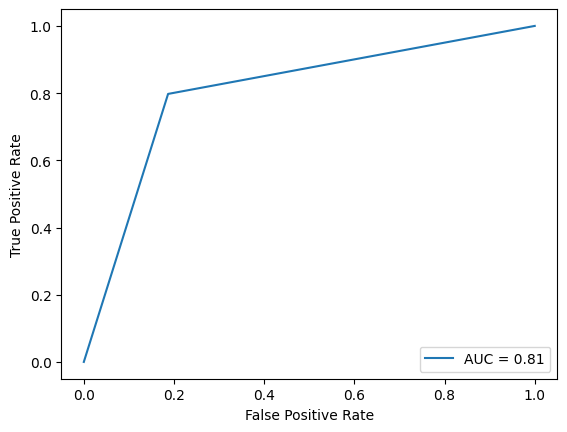

In [ ]:
# Logistic regression: outcome is selective
df1_train, df1_test = train_test_split(df1_log, test_size = 0.2, random_state = 0)
inputs = df1_log.columns[:17]

X = df1_train[inputs]
y = df1_train["selective"]
model = LogisticRegression(penalty = None).fit(X, y)

test_pred = model.predict(df1_test[inputs])
test_true_all = df1_test["selective"]

fpr, tpr, thresholds = metrics.roc_curve(test_true_all, test_pred)
auc_all = metrics.roc_auc_score(test_true_all, test_pred)
roc_curve = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc_all)
roc_curve.plot()
plt.show()

In [ ]:
# Outcome = selective
print(f"auc for all: {auc_all:.4f}")

metric_bin_generate(metrics.roc_auc_score, "selective", "auc")

fpr_all = metrics.precision_score(test_true_all, test_pred)
print()
print(f"FPR for all: {fpr_all:.4f}")
metric_bin_generate(metrics.precision_score, "selective", "FPR")
print()
m_inter = model.intercept_
m_coefs = model.coef_

for i in range(len(inputs_select)):
  print(f"{inputs_select[i]} coefficient is: {m_coefs[0][i]:.4f}")

auc for all: 0.8054
auc for income bin 0-20: 0.9167
auc for income bin 20-40: 0.8571
auc for income bin 40-60: 0.7689
auc for income bin 60-70: 0.9333
auc for income bin 70-80: 0.7710
auc for income bin 80-90: 0.8125
auc for income bin 90-95: 0.8000
auc for income bin 95-96: 0.8318
auc for income bin 96-97: 0.8056
auc for income bin 97-98: 0.6857
auc for income bin 98-99: 0.9355
auc for income bin 99-99.9: 0.7750
auc for income bin 1: 0.8846
auc for income bin 0.1: 0.5833

FPR for all: 0.5403
FPR for income bin 0-20: 0.5556
FPR for income bin 20-40: 0.4545
FPR for income bin 40-60: 0.6250
FPR for income bin 60-70: 0.6667
FPR for income bin 70-80: 0.3333
FPR for income bin 80-90: 0.5385
FPR for income bin 90-95: 0.5000
FPR for income bin 95-96: 0.7273
FPR for income bin 96-97: 0.5556
FPR for income bin 97-98: 0.5000
FPR for income bin 98-99: 0.6364
FPR for income bin 99-99.9: 0.5000
FPR for income bin 1: 0.4545
FPR for income bin 0.1: 1.0000

rel_attend coefficient is: 0.2326
bin_0-20 c

## Results

**For elite selectivity:**

The auc score for all inputs is 0.8172, which indicates the model is a good predictor.

The false positive rate for all inputs is .7769. The income bin with the largest FPR is top 0.1 with .9333, while the income bin with the smallest FPR is 40-60 with 0.6250.

Our model estimates that, all else equal, if the college is private, the odds of the college having elite selectivity are increased. The odds are multiplied by around 6.32 $(e^{1.8442})$.

Our model estimates that, all else equal, if the student is in the top 0.1 income bin, the odds of the college having elite selectivity are increased. The odds are multiplied by around 1.46 $(e^{0.3760})$.


Our model estimates that, for alse equal, if the student is in the 0-20 income bin, the odds of the college having elite selectivity are decreased. The odds are multiplied by around 0.73 $(e^{-0.2471})$.

**For high selectivity**

Currently, the model has an auc of 0.5, and FPR of 0.0 for all inputs (together and individually). This indicates that either the model is as good as random guessing (so not good) or there is an issue with how the model was developed.

**For selectivity:**

The auc score for all inputs is 0.8054, which indicates the model is a good predictor.

The false positive rate for all inputs is 0.5403. The income bin with the largest FPR is top 0.1 with 1.0000, while the income bin with the smallest FPR is bin 70-80 with 0.3333.

Our model estimates that, all else equal, if the college is private, the odds of the college having regular selectivity are decreased. The odds are multiplied by around 0.11 $(e^{-2.2227})$.

Our model estimates that, all else equal, if the student is in the top 0.1 income bin, the odds of the college having regular selectivity are decreased. The odds are multiplied by around 0.73 $(e^{-0.3105})$.

Our model estimates that, all else equal, if the student is in the 0-20 income bin, the odds of the college having regular selectivity are increased. The odds are multiplied by around 1.05 $(e^{0.0567})$.

**Overall**

Using the inputs of the parental income bins (binary), relative attendance (numeric) and private/public status (binary), we can notice that the elite selective and selective college models have an auc of 0.8172 and 0.8054, respectively. This indicates that these models are relatively good at predicting the selectivity.

However, there is a lot of differences between the income bins. For example, in the elite selective model, the FPR of top 0.1 is 0.9333 which indicates that if a students is in the top 0.1 income bin, they very likely to be predicted attending an elite selective college a majority of the time. On the other hand, for the income bin of 40-60, they have an FPR of 0.6250. This is a difference of 0.3083, which is quite large. The model is definitely does not work well on the level of the sensitive attributes. Judging by the elite selective model's coefficients, we can see that students in the income bin 0-20 reduce the likelihood of being elite selective wherease students in the top 0.1 bin enhance the likelihood of being elite selective. In contrast, we can see that students in the income bin 0-20 increase the likelihood of being in a selective school whereas students in the top 0.1 bin reduce the likelihood of being in a selective school. This indicates that having a larger parental income, increases the chances of being in an elite selective college, while have a smaller parental income increases the chances of being in a selective college.

# Dataset 2 - College Selectivity and Race

This data includes at the racial makeup of American Universities of varying selectivity levels.


**Data Dictionary / important features**

`year` = fall semester year

`slevel` = 4 or 2 year

`college` = college name

`selective`, more `selective`, `non_selective` = how selective school is

`total_enrollment` = enrollment amount

`col_white` = college percent white

`mkt_white` = market percent white defined geographically according to institutions’ level, degree of selectivity, and urbanicity

`dif_white` = college Representation of White Population (col_white - mkw_white)

... same for the rest of the race groups

`amind` = American Indian

`pacis` = Pacific Islander

`twora` = Multiracial

Our sensitive features of interest would be the breakdown of the college’s racial composition (col_white, col_black, col_hispanic, col_asian, etc.)


## Pre Processing

An important step to take with this dataset involves renaming the variables to more recognizeable words and removing all 'NaN values.

In [ ]:
df2 = df2.rename(columns = {"fips_ipeds" : "state", "inst_name" : "college", "slevel" : "type", "fourcat" : "selectivity"})
df2[["col_white", "col_black", "col_hispa", "col_asian", "col_amind", "col_pacis", "col_twora", "dif_white", "dif_black", "dif_hispa", "dif_asian", "dif_amind", "dif_pacis", "dif_twora"]] = df2[["col_white", "col_black", "col_hispa", "col_asian", "col_amind", "col_pacis", "col_twora", "dif_white", "dif_black", "dif_hispa", "dif_asian", "dif_amind", "dif_pacis", "dif_twora"]].fillna(0.0)
df2

,unitid,year,state,college,type,selectivity,public,private,forprofit,selective,...,dif_asian,col_amind,mkt_amind,dif_amind,col_pacis,mkt_pacis,dif_pacis,col_twora,mkt_twora,dif_twora
0,100654,2009,Alabama,Alabama A & M University,4-year,Public Selective,1,0,0,1,...,-0.741711,0.200758,0.564552,-0.363794,0.000000,0.155576,0.000000,0.000000,1.528652,0.000000
1,100654,2010,Alabama,Alabama A & M University,4-year,Public Selective,1,0,0,1,...,-0.895135,0.060852,0.581733,-0.520881,0.000000,0.089841,-0.089841,0.000000,1.654546,-1.654546
2,100654,2011,Alabama,Alabama A & M University,4-year,Public Selective,1,0,0,1,...,-0.953688,0.072957,0.499614,-0.426656,0.024319,0.047023,-0.022703,0.000000,1.617237,-1.617237
3,100654,2012,Alabama,Alabama A & M University,4-year,Public Selective,1,0,0,1,...,-1.062909,0.049008,0.502863,-0.453855,0.024504,0.035682,-0.011178,0.000000,1.604016,-1.604016
4,100654,2013,Alabama,Alabama A & M University,4-year,Public Selective,1,0,0,1,...,-0.952295,0.123426,0.615549,-0.492122,0.098741,0.044647,0.054094,0.000000,1.790837,-1.790837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17262,240727,2013,Wyoming,University of Wyoming,4-year,Public More Selective,1,0,0,0,...,0.281356,0.662052,2.563285,-1.901233,0.290902,0.050326,0.240575,2.206841,3.420510,-1.213668
17263,240727,2014,Wyoming,University of Wyoming,4-year,Public More Selective,1,0,0,0,...,0.348824,0.565086,2.498113,-1.933027,0.292634,0.214747,0.077887,2.603431,3.504740,-0.901309
17264,240727,2015,Wyoming,University of Wyoming,4-year,Public More Selective,1,0,0,0,...,0.207345,0.609632,2.397501,-1.787868,0.243853,0.380927,-0.137074,3.098963,3.475123,-0.376159
17265,240727,2016,Wyoming,University of Wyoming,4-year,Public More Selective,1,0,0,0,...,0.141128,0.613178,2.288063,-1.674884,0.207857,0.416011,-0.208154,3.440033,3.091336,0.348697


## Summary Statistics

The initial dataframe contained 17,168 rows and 34 columns overall and per sensitive attribute group.

Our sensitive variables of interst are the percentages of different racial groups at each college [`col_white`, `col_black`, `col_hispa`, `col_asian`, `col_pacis`, `col_twora`, `col_amind`].

The outcome variable we will be predicting is the selectivity level of each college [`selective`, `non-selective`, `more_selective`]


In [ ]:
#Mean, Median, Standard Deviation for outcome variables
outputs = ["selective", "non_selective", "more_selective"]
print()
for i in range(len(outputs)):
  avg_i = df2[outputs[i]].mean()
  med_i = df2[outputs[i]].median()
  std_i = df2[outputs[i]].std()
  print(f"Mean for {outputs[i]}: {avg_i:.4f}")
  print(f"Median for {outputs[i]}: {med_i:.4f}")
  print(f"Standard Deviation for {outputs[i]}: {std_i:.4f}")
  print()


Mean for selective: 0.4568
Median for selective: 0.0000
Standard Deviation for selective: 0.4981

Mean for non_selective: 0.3287
Median for non_selective: 0.0000
Standard Deviation for non_selective: 0.4697

Mean for more_selective: 0.2145
Median for more_selective: 0.0000
Standard Deviation for more_selective: 0.4105



The Mean Median, and Std are non very stastistically significant for the output variables as the data is either 0 or 1 for whether a college belongs in each category. It does show us there is the most representaiton for selective colleges in the dataset, followed by non_selective, and the least representaiton for more_selective colleges.

In [ ]:
#Mean, Median, Standard Deviation for sensitive subgroups
sensitive_groups = ["col_white", "col_black", "col_hispa", "col_asian", "col_twora", "col_pacis", "col_amind"]
print()
for i in range(len(sensitive_groups)):
  avg_i = df2[sensitive_groups[i]].mean()
  med_i = df2[sensitive_groups[i]].median()
  std_i = df2[sensitive_groups[i]].std()
  print(f"Mean for {sensitive_groups[i]}: {avg_i:.4f}")
  print(f"Median for {sensitive_groups[i]}: {med_i:.4f}")
  print(f"Standard Deviation for {sensitive_groups[i]}: {std_i:.4f}")
  print()


Mean for col_white: 58.5548
Median for col_white: 64.5533
Standard Deviation for col_white: 24.9149

Mean for col_black: 14.4744
Median for col_black: 7.2420
Standard Deviation for col_black: 19.8685

Mean for col_hispa: 9.4808
Median for col_hispa: 5.6917
Standard Deviation for col_hispa: 11.5490

Mean for col_asian: 4.1871
Median for col_asian: 1.9584
Standard Deviation for col_asian: 6.4730

Mean for col_twora: 2.2836
Median for col_twora: 1.9183
Standard Deviation for col_twora: 2.4524

Mean for col_pacis: 0.2840
Median for col_pacis: 0.0743
Standard Deviation for col_pacis: 1.4587

Mean for col_amind: 0.7543
Median for col_amind: 0.3368
Standard Deviation for col_amind: 2.7285



The mean, median, and standard deviation for the sensitive groups show that there is higher amounts of enrollment for white students across the dataset and much lower enrollement for minorities.

Grouping by year, we will look at the trends of the differences of racial population for all colleges in the dataset.

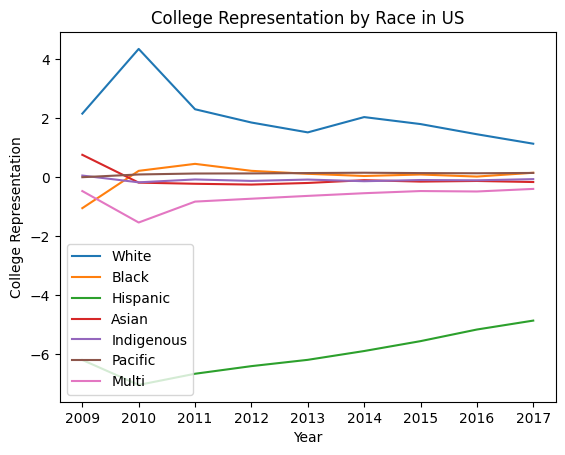

In [ ]:
df2_year = df2.groupby("year").mean("dif_white")

w, b = df2_year["dif_white"], df2_year["dif_black"]
h, a = df2_year["dif_hispa"], df2_year["dif_asian"]
i, p, t = df2_year["dif_amind"], df2_year["dif_pacis"], df2_year["dif_twora"]

plt.plot(w)
plt.plot(b)
plt.plot(h)
plt.plot(a)
plt.plot(i)
plt.plot(p)
plt.plot(t)

plt.xlabel("Year")
plt.ylabel("College Representation")
plt.title("College Representation by Race in US")
plt.legend(["White", "Black", "Hispanic", "Asian", "Indigenous", "Pacific", "Multi"])
plt.show()

For reference, positive numbers indicate an overrepresentation (i.e. there are more students of that race enrolled in the college compared to the corresponding market), while negative numbers indicate an underrepresentation. The number 0 should indicate a well-represented population (the college population is the same as the market population for that racial group).

We can notice that white students seem to consistently be overrepresented in the college populations. However, there is a slight decrease over time in this representation. The racial population that is the most underrepresented seems to be Hispanics. However, there is a slight increase in the representation of this group. Indigenous, Black, and Pacific populations seem to be well represented.

Now, we will look at the trends of the differences of racial populations by year for only Ivy League schools. Since Ivy League colleges are part of the "More Selective Private" group, the market of race populations depend on the entire nation.

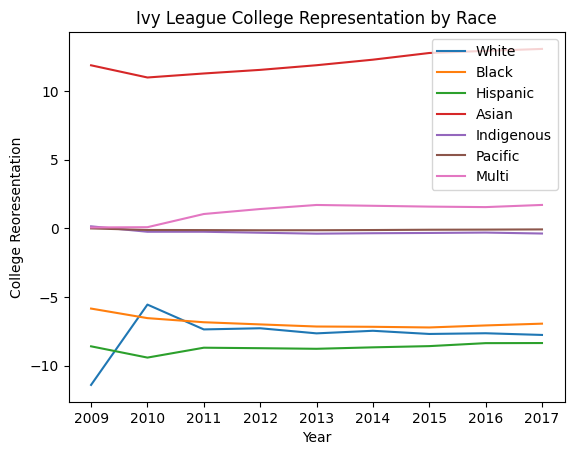

In [ ]:
ivies = ["Cornell University", "Columbia University in the City of New York",
         "Dartmouth College", "Harvard University", "Yale University", "Princeton University",
         "University of Pennsylvania", "Brown University"]

ivy_df2 = df2["college"].isin(ivies)

df2_year_ivy = df2[ivy_df2].groupby("year").mean("dif_white")

w, b = df2_year_ivy["dif_white"], df2_year_ivy["dif_black"]
h, a = df2_year_ivy["dif_hispa"], df2_year_ivy["dif_asian"]
i, p, t = df2_year_ivy["dif_amind"], df2_year_ivy["dif_pacis"], df2_year_ivy["dif_twora"]

plt.plot(w)
plt.plot(b)
plt.plot(h)
plt.plot(a)
plt.plot(i)
plt.plot(p)
plt.plot(t)

plt.xlabel("Year")
plt.ylabel("College Reoresentation")
plt.title("Ivy League College Representation by Race")
plt.legend(["White", "Black", "Hispanic", "Asian", "Indigenous", "Pacific", "Multi"])
plt.show()

We can notice that Asian students seem to be overrepresented while White, Black, and Hispanic students are underrepresented in Ivy Leagues. Students who are either Indigeneous, Pacific or Multiracial seem to be well represented.

We will now look at the differences of racial populations based on the selectivity of the college. Public More Selective colleges consider the entire state as their market. Private More Selective colleges consider the entire nation as their market. Less selective colleges use the commuting radius as their market.

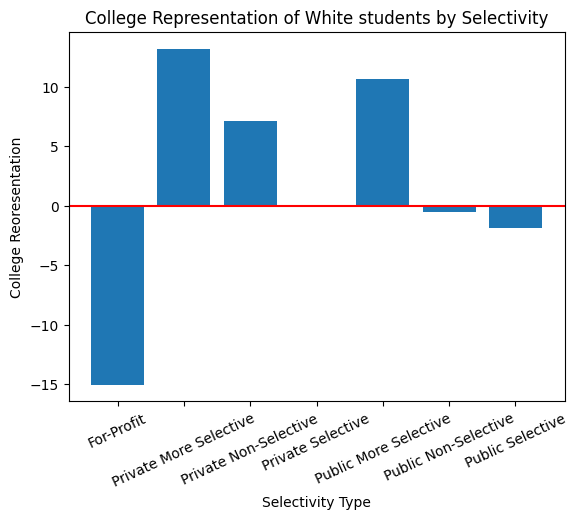

In [ ]:
df2_select = df2.groupby("selectivity").mean("dif_white")
df2_select

x_select = ["For-Profit", "Private More Selective", "Private Non-Selective",
            "Private Selective", "Public More Selective",
            "Public Non-Selective", "Public Selective"]

plt.bar(x_select, df2_select["dif_white"])
plt.xlabel("Selectivity Type")
plt.xticks(rotation = 25)
plt.ylabel("College Reoresentation")
plt.title("College Representation of White students by Selectivity")
plt.axhline(y = 0, color = "r")
plt.show()

It seems that White students are considerably underrepresented in For-Profit colleges, while overrepresented in Private More Selective, Private Non-Selective, and Private More Selective. It seems that White students are well-represented in Private Selective colleges, judging by the lack of a bar.

We will produce the same for Black students.

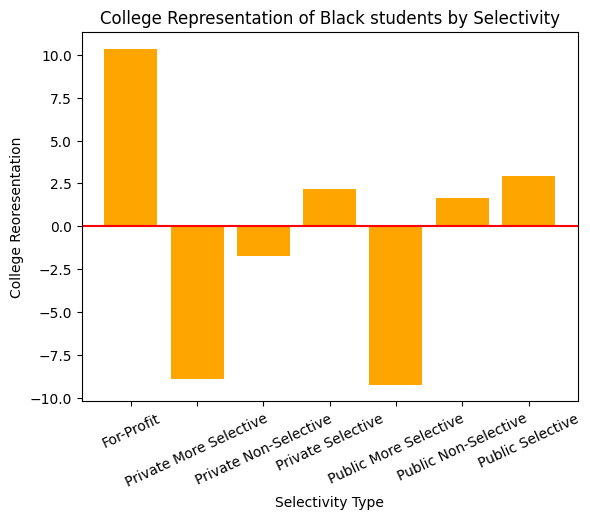

In [ ]:
x_select = ["For-Profit", "Private More Selective", "Private Non-Selective",
            "Private Selective", "Public More Selective",
            "Public Non-Selective", "Public Selective"]

plt.bar(x_select, df2_select["dif_black"], color = "orange")
plt.xlabel("Selectivity Type")
plt.xticks(rotation = 25)
plt.ylabel("College Reoresentation")
plt.title("College Representation of Black students by Selectivity")
plt.axhline(y = 0, color = "r")
plt.show()

It seems that Black students are underrepresented in Private More Selective and Public More Selective colleges, while overrepresented in For-Profit colleges.

## Research Question

**Research Question**

We want to use the data to answer the question: How does race indicate the selectivity of institutions?

**Hypothesis**

The data on white students is more predictive of model performance than the data on Black students as the selectivity of the school increases.

**Analysis Plan**


In order to detect racial bias using this datatset, we have decided to use two different model types - Logstic Regression and Random Forest Classifier - to compare white vs Black students in their weight in predicting the selectivity of a school. Selectivity of a school often reflects its prestige and quality of education, and more selective schools are histrically partial towards its white, wealthy, and legacy students. Through comparing how accurate these models are without the white students as an input variable and the Black students as input variables, respectively, for the three selectivity levels of school: more selective, selective and not selective, we can glimpse into the potential racial biases embedded within the admissions processes of educational institutions, and call into question what exactly makes a school "selective" based on its student racial representation. By examining the predictive power of race on school selectivity, we aim to uncover any disparities or favoritism towards certain racial groups. We have chosen the white student population and the Black student population as our two comparison groups.

To do this, for our two model types, we have done the same analysis. We have split the input variables intwo three subgroups:

1) all race groups, as a baseline (`everyone`)

2) all race groups **without white students** (`white_missing`)

3) all race groups **without Black students** (`Black_missing`)

And we calculate the AUC scores for each of the selectivity levels of schools:

1) more selective (`more_selective`)

2) selective (`selective`)

3) not selective (`non_selective`)

Thus, running each of the two models nine times, for each pairing, allows us to assess the predictive power of different racial subgroups in determining school selectivity. By calculating the AUC scores for each model and dividing the AUC scores of the second and third racial subgroups (without White and without Black) from the first, we can determine the fraction of the race-based AUC score from the baseline AUC score for each selectivity type. The fraction will be calculated as:

> (`everyone` AUC - `white_missing` OR `Black_missing` AUC) / `everyone` AUC


...for each of the 3 selectivity levels


These fraction scores reveal how much of the baseline AUC score is attributable to that racial group's predictive power. Comparing these values across selectivity levels will reveal how much of the accuracy of the model depends on the racial groups depending on how selective the institution. Understanding their predictive power for each selectivity level provides insight into the extent to which that race influences the admissions processes of each type of educational institutions.

Below, we are starting with the Logistic Regression models. We have produced  graphs that visualize each of the three selectivity levels using all of the race groups, just to analyze how well the models perform when considering the entire racial composition of the dataset. These visualizations provide an initial overview of the discriminatory power of the models across different selectivity levels.

## Models for our second dataset - Race Groups on Selectivity of Institutions Analysis



### Models Part 1: Logistic Regression

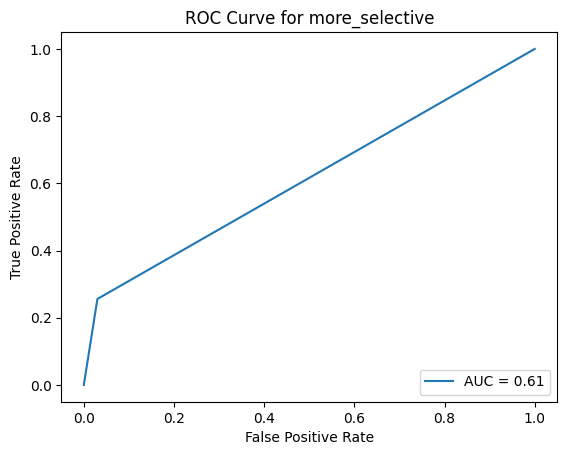

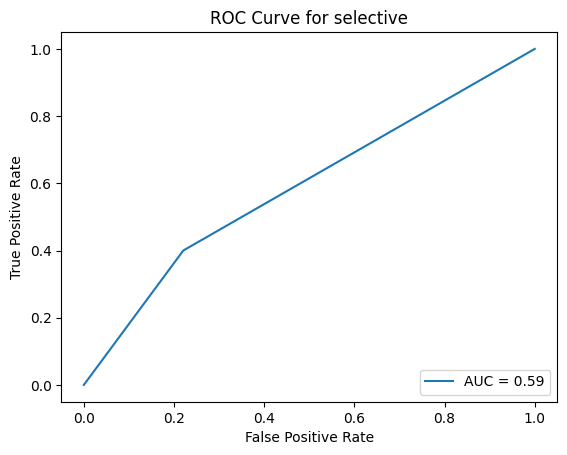

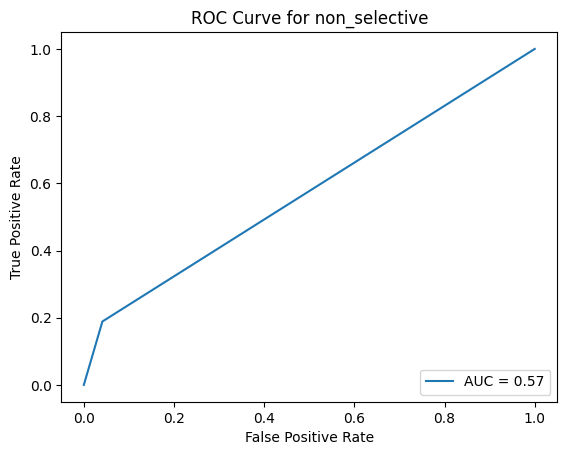

In [ ]:
# Logistic Regression graphs
df2_rf = df2[["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora", "selective", "more_selective", "non_selective"]]
df2_train, df2_test = train_test_split(df2_rf, test_size=0.2, random_state=0)
inputs_one = df2_rf.columns[:7]  # all race groups

selectivity = ['more_selective', 'selective', 'non_selective']

for i in range(3):
  X = df2_train[inputs_one]
  y = df2_train[selectivity[i]]
  modeltwo = LogisticRegression(penalty = None).fit(X, y)

  test_pred_two = modeltwo.predict(df2_test[inputs_one])
  test_true_all_two = df2_test[selectivity[i]]

  fpr_two, tpr_two, thresholds_two = metrics.roc_curve(test_true_all_two, test_pred_two)
  auc_all_two = metrics.roc_auc_score(test_true_all_two, test_pred_two)
  roc_curve_two = metrics.RocCurveDisplay(fpr=fpr_two, tpr=tpr_two, roc_auc=auc_all_two)
  roc_curve_two.plot()
  title = "ROC Curve for " + selectivity[i]
  plt.title(title)
  plt.show()

As we can see above, the AUC scores using all of the race groups decrease as the selectivity level decreases. This could be an indication of a lack of discriminatory power in the model when considering all racial groups simultaneously, suggesting that certain racial groups may have a stronger influence on predicting higher selectivity levels than others.

Now that we have visulized the baseline AUC scores for each selectivity level, we will calculate the AUC levels with the race subgroups disucssed above as inputs.

In [ ]:
input_variable_groups = {
    "everyone": ["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"], # everyone
    "white_missing": ["col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"], # not using white people
    "Black_missing": ["col_white", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"] # not using Black people
}


auc_scores = {}

output_variables = ["more_selective", "selective", "non_selective"]
selectivity = ['more_selective', 'selective', 'non_selective']

for output_variable in output_variables:
    auc_scores[output_variable] = {}

    for group_name, input_variables in input_variable_groups.items():
        df2_rf = df2[["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora", output_variable]]
        df2_train, df2_test = train_test_split(df2_rf, test_size=0.2, random_state=0)
        inputs_one = df2_rf.columns[:7]  # all race groups

        X = df2_train[input_variables]
        y = df2_train[output_variable]
        model_two = LogisticRegression(penalty = None).fit(X, y)

        test_pred_two = model_two.predict(df2_test[input_variables])
        test_true_all_two = df2_test[output_variable]

        auc_all_two = metrics.roc_auc_score(test_true_all_two, test_pred_two)

        auc_scores[output_variable][group_name] = auc_all_two

print(auc_scores)


{'more_selective': {'everyone': 0.6128500542322507, 'white_missing': 0.6127169227229362, 'Black_missing': 0.5768003022336453}, 'selective': {'everyone': 0.589697950377562, 'white_missing': 0.5570135517799353, 'Black_missing': 0.5670051240560949}, 'non_selective': {'everyone': 0.5737980061221379, 'white_missing': 0.547730786377269, 'Black_missing': 0.5529983615468923}}


In [ ]:
# Rounding AUC scores to 4 decimal points
for key, value in auc_scores.items():
    for subkey, subvalue in value.items():
        auc_scores[key][subkey] = round(subvalue, 4)

table_data = []
for key, value in auc_scores.items():
    row = [key]
    for subkey, subvalue in value.items():
        row.extend([subkey, subvalue])
    table_data.append(row)

headers = ['Outcome Variable', 'Group', 'AUC Score']
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+----------------+----------+--------+---------------+--------------------+---------------+-------------+
|                |          |        |               |   Outcome Variable | Group         |   AUC Score |
+================+==========+========+===============+====================+===============+=============+
| more_selective | everyone | 0.6129 | white_missing |             0.6127 | Black_missing |      0.5768 |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+
| selective      | everyone | 0.5897 | white_missing |             0.557  | Black_missing |      0.567  |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+
| non_selective  | everyone | 0.5738 | white_missing |             0.5477 | Black_missing |      0.553  |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+


In [ ]:
auc_diff = {}
for outcome, scores in auc_scores.items():
    auc_diff[outcome] = {
        'white group fraction': round((scores['everyone'] - scores['white_missing']) / scores['everyone'], 4),
        'Black group fraction': round((scores['everyone'] - scores['Black_missing']) / scores['everyone'], 4)
    }

table_data = []
for outcome, diffs in auc_diff.items():
    row = [outcome]
    for group, diff in diffs.items():
        row.extend([group, diff])
    table_data.append(row)

headers = ['Outcome Variable', 'Group Difference', 'AUC Difference']
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+----------------+----------------------+--------------------+----------------------+------------------+
|                |                      |   Outcome Variable | Group Difference     |   AUC Difference |
+================+======================+====================+======================+==================+
| more_selective | white group fraction |             0.0003 | Black group fraction |           0.0589 |
+----------------+----------------------+--------------------+----------------------+------------------+
| selective      | white group fraction |             0.0555 | Black group fraction |           0.0385 |
+----------------+----------------------+--------------------+----------------------+------------------+
| non_selective  | white group fraction |             0.0455 | Black group fraction |           0.0362 |
+----------------+----------------------+--------------------+----------------------+------------------+


### Models Part 2: Random Forest Classifier

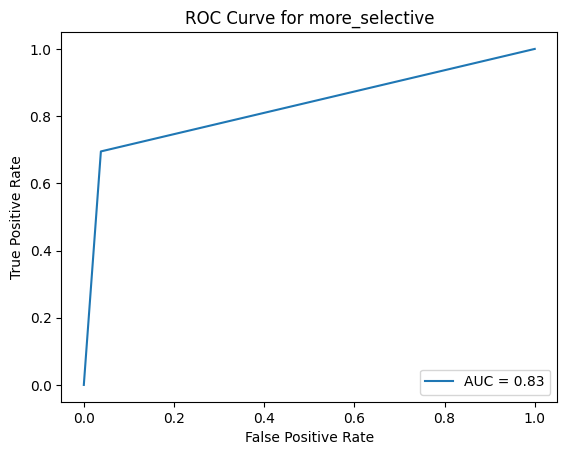

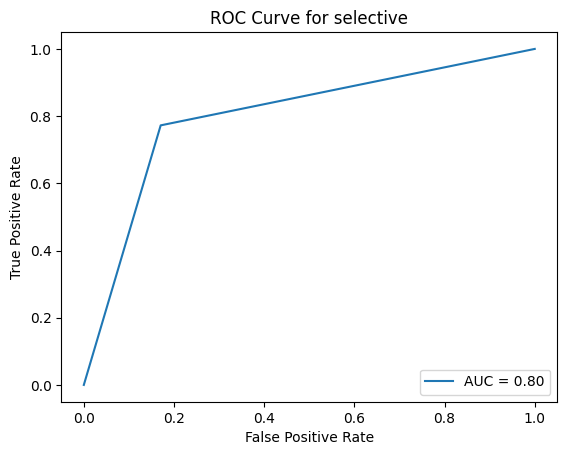

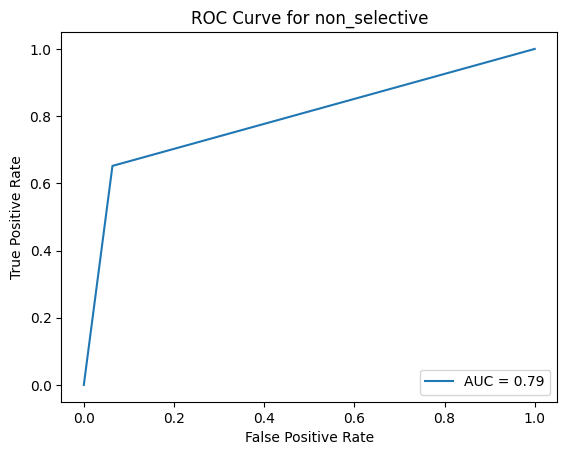

In [ ]:
# Random Forest for selective
df2_rf = df2[["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora", "selective", "more_selective", "non_selective"]]
df2_train, df2_test = train_test_split(df2_rf, test_size=0.2, random_state=0)
inputs_one = df2_rf.columns[:7]  # all race groups

selectivity = ['more_selective', 'selective', 'non_selective']

for output_variable in selectivity:
    X = df2_train[inputs_one]
    y = df2_train[output_variable]
    model_two = RandomForestClassifier(random_state=0).fit(X, y)

    test_pred_two = model_two.predict(df2_test[inputs_one])
    test_true_all_two = df2_test[output_variable]

    fpr_two, tpr_two, thresholds_two = metrics.roc_curve(test_true_all_two, test_pred_two)
    auc_all_two = metrics.roc_auc_score(test_true_all_two, test_pred_two)
    roc_curve_two = metrics.RocCurveDisplay(fpr=fpr_two, tpr=tpr_two, roc_auc=auc_all_two)
    roc_curve_two.plot()
    title = "ROC Curve for " + output_variable
    plt.title(title)
    plt.show()



Like with the Logistic Regression models, we can see that the AUC scores decrease as selectivity level decreases.

Now, were going to look at race subgroups and the selectivity level to compare AUC scores

In [ ]:
input_variable_groups = {
    "everyone": ["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"], # everyone
    "white_missing": ["col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"], # not using white people
    "Black_missing": ["col_white", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora"] # not using Black people
}

auc_scores = {}

output_variables = ["more_selective", "selective", "non_selective"]
selectivity = ['more_selective', 'selective', 'non_selective']

for output_variable in output_variables:
    auc_scores[output_variable] = {}

    for group_name, input_variables in input_variable_groups.items():
        df2_rf = df2[["col_white", "col_black", "col_hispa", "col_asian", "col_pacis", "col_amind", "col_twora", output_variable]]
        df2_train, df2_test = train_test_split(df2_rf, test_size=0.2, random_state=0)
        inputs_one = df2_rf.columns[:7]  # all race groups

        X = df2_train[input_variables]
        y = df2_train[output_variable]
        model_two = RandomForestClassifier(random_state=0).fit(X, y)

        test_pred_two = model_two.predict(df2_test[input_variables])
        test_true_all_two = df2_test[output_variable]

        auc_all_two = metrics.roc_auc_score(test_true_all_two, test_pred_two)

        auc_scores[output_variable][group_name] = auc_all_two

print(auc_scores)


{'more_selective': {'everyone': 0.8285562566031973, 'white_missing': 0.8168273706325956, 'Black_missing': 0.7755535884467973}, 'selective': {'everyone': 0.8010288565264293, 'white_missing': 0.7864913700107875, 'Black_missing': 0.770981998381877}, 'non_selective': {'everyone': 0.7941667020028552, 'white_missing': 0.7720706968258172, 'Black_missing': 0.7717878163114138}}


In [ ]:
for key, value in auc_scores.items():
    for subkey, subvalue in value.items():
        auc_scores[key][subkey] = round(subvalue, 4)

table_data = []
for key, value in auc_scores.items():
    row = [key]
    for subkey, subvalue in value.items():
        row.extend([subkey, subvalue])
    table_data.append(row)

headers = ['Outcome Variable', 'Group', 'AUC Score']
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+----------------+----------+--------+---------------+--------------------+---------------+-------------+
|                |          |        |               |   Outcome Variable | Group         |   AUC Score |
+================+==========+========+===============+====================+===============+=============+
| more_selective | everyone | 0.8286 | white_missing |             0.8168 | Black_missing |      0.7756 |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+
| selective      | everyone | 0.801  | white_missing |             0.7865 | Black_missing |      0.771  |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+
| non_selective  | everyone | 0.7942 | white_missing |             0.7721 | Black_missing |      0.7718 |
+----------------+----------+--------+---------------+--------------------+---------------+-------------+


Now, we'll take a look at the differences between AUC scores between the baseline (`everyone`) and the `white_missing` and `Black_missing`.

In [ ]:
auc_diff = {}
for outcome, scores in auc_scores.items():
    auc_diff[outcome] = {
        'white group fraction': round((scores['everyone'] - scores['white_missing']) / scores['everyone'], 4),
        'Black group fraction': round((scores['everyone'] - scores['Black_missing']) / scores['everyone'], 4)
    }

table_data = []
for outcome, diffs in auc_diff.items():
    row = [outcome]
    for group, diff in diffs.items():
        row.extend([group, diff])
    table_data.append(row)

headers = ['Outcome Variable', 'Group Difference', 'AUC Difference']
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+----------------+----------------------+--------------------+----------------------+------------------+
|                |                      |   Outcome Variable | Group Difference     |   AUC Difference |
+================+======================+====================+======================+==================+
| more_selective | white group fraction |             0.0142 | Black group fraction |           0.064  |
+----------------+----------------------+--------------------+----------------------+------------------+
| selective      | white group fraction |             0.0181 | Black group fraction |           0.0375 |
+----------------+----------------------+--------------------+----------------------+------------------+
| non_selective  | white group fraction |             0.0278 | Black group fraction |           0.0282 |
+----------------+----------------------+--------------------+----------------------+------------------+


## Results

**Logstic Regression models:**

Looking at the `selective` and `non_selective` colleges, the difference between the baseline AUC scores and the AUC scores without the white group is larger than the difference between the baseline and the AUC score without the Black group. This is an indication that the model without the Black student population is better performing than the model witout the white student, making the white students more statistically significant for the performance of the model than the Black students. However, this difference is not a large amount: about 0.01 for selective and 0.005 for the `non_selective`.


For the `more_selective` schools, however, the findings are telling. Taking away the Black student population decreased the model's performance by approximately 0.06, whereas removing the white student population barely affected the performance at all (0.0003). This could be for a number of reasons, including the historical and systemic biases prevalent in educational systems that disproportionately affect Black students, leading to their stronger influence on the model's predictive power. Additionally, it may reflect the underrepresentation of Black students in selective schools compared to white students, which could lead to more pronounced patterns and associations in the data for this racial group. Furthermore, it's possible that the features or characteristics associated with Black students play a more significant role in determining selectivity levels, resulting in a larger impact on the model's performance when these features are excluded.

**Random Forest Classifiers models:**

The white student group has the most influence on the performance of the model for the `non_selective` schools with an AUC fraction of 0.0278, and the Black student group has the most influence on the performance of the model for `more_selective` schools with an AUC fraction of 0.064. This phenomenon could stem from systemic disparities and historical patterns prevalent in educational systems. Non-selective schools often serve more diverse populations, including a higher proportion of white students. Consequently, the characteristics and attributes associated with white students may have a stronger influence on the model's predictive power for these schools. On the other hand, more selective schools are historically known to have admissions processes that favor white, wealthy, and legacy students. This bias in the selection process may lead to stronger associations between selectivity levels and features associated with Black students, resulting in a greater impact on the model's performance when these features are excluded. Additionally, societal factors such as institutional racism and socioeconomic disparities may also contribute to the differential influence of racial groups on the model's performance across different types of schools.

**Overall**

We can see from the AUC scores that the Random Forest Classifier has a better performance than the Logstic Regression models, just looking at the `everyone` group for both model types. For Logstic Regression, the AUC scores were around between 0.57 and 0.61, and for the Random Forest Classifier, they AUC scores are between 0.88 and 0.95, which is singificantly higher performing. All in all, the Random Forest Classifier seemed to have a better performance than the Logistic Regression in comparing AUC scores, where all of the Random Forest Classifier scores were significantly higher than the Logistic Regression scores. This suggests that the Random Forest Classifier may be better suited for capturing the complex relationships between race and selectivity levels in educational institutions.

In terms of our hypothesis, where we precicted: "The data on white students is more predictive of model performance than the data on Black students as the selectivity of the school increases", it appears that the hypothesis is not supported for the most part. Taking a look at data from the Random Forest Classifier, for the `more_selective` schools,  the AUC score decreases the most when the data on Black students is missing, indicating that the presence of data on Black students contributes more to the model's performance compared to when the data on white students is missing. This does not align with the hypothesis. For the `selective` schools, similar to the `more_selective` schools, the AUC score decreases more noticeably when the data on Black students is missing compared to when the data on white students is missing, not supporting the hypothesis. Lastly, for the `non_selective` schools, the differences in AUC scores between the scenarios with missing data on white and Black students are less pronounced. However, the AUC score is slightly higher when the data on white students is missing compared to when the data on Black students is missing. This does support the hypothesis, but the difference is very minimal.

Overall, while there is some support for the hypothesis based on the provided data, it's important to consider additional factors such as sample size, data quality, and potential confounding variables. Further exploration of these underlying dynamics and their implications is essential for understanding and addressing the observed disparities in model performance.

One further exploration for this analysis could include measuring the significance of other race groups, not just white and Black student populations.

## Contributions

Alexia: df1 data cleaning, df1 summary statistics, df1 research plan, df1 model, df1 results, df2 data cleaning, df2 summary statistics

Nuray: df1 and df2 data imports and preliminary graphs, df1 and sf2 data dictionaries, df2 model coding, finalization and df2 result interpretation writeup.

Srinitya: df2 data pre-processing, df2 research question/hypothesis, df2 summary statistics, df2 (logistic regression) model coding, df1 and df2 editing, works cited


## Works Cited


Data Sources:



Monarrez, T. and Washington, K. (2020) Racial and ethnic representation in postsecondary education, Urban Institute. https://www.urban.org/research/publication/ racial-and-ethnic-representation -postsecondary-education



Chetty, Raj et al. 2023. Diversifying Society’s Leaders? The Determinants and Causal Effects of Admission to Highly Selective Private Colleges. Opportunity Insights. https://opportunityinsights.org/paper/collegeadmissions/

For Logistic Regression models: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

For Random Forest Classifier models: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#Professor K Feedback

* should check to make sure the race percentages sum to 1. If not, add that detail in data summary.
* check for collinearity between columns
* Average per school over the years
* New model idea:
  * use multiclass linea gression for the 3 selectivity levels
  * 3 input data groups: 1. features with no race data, 2. features with no White data and POC as one percentage, and 3. features with no White data and granular
  * If not looking at coefs: ex hyp = granular race data better predicts selectivity
  * If looking at coefs: ex hyp = higher white student population better predicts selectivity
